# Optimize costs of shiping to improve it 

### Models libraries imports

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

### Preprcessing, pipeline, metrics libraries imports

In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_error, PredictionErrorDisplay

### data, plots libraries imports

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Read data from file as a dataframe

In [4]:
data = pd.read_csv("data.csv", encoding='latin-1') # I used encoding because it could not run directly

print(data.head(10))
print("number of rows is : ",data.count())

   Row ID         Order ID  Order Date   Ship Date       Ship Mode  \
0   32298   CA-2012-124891  31-07-2012  31-07-2012        Same Day   
1   26341    IN-2013-77878  05-02-2013  07-02-2013    Second Class   
2   25330    IN-2013-71249  17-10-2013  18-10-2013     First Class   
3   13524  ES-2013-1579342  28-01-2013  30-01-2013     First Class   
4   47221     SG-2013-4320  05-11-2013  06-11-2013        Same Day   
5   22732    IN-2013-42360  28-06-2013  01-07-2013    Second Class   
6   30570    IN-2011-81826  07-11-2011  09-11-2011     First Class   
7   31192    IN-2012-86369  14-04-2012  18-04-2012  Standard Class   
8   40155   CA-2014-135909  14-10-2014  21-10-2014  Standard Class   
9   40936   CA-2012-116638  28-01-2012  31-01-2012    Second Class   

  Customer ID     Customer Name      Segment           City            State  \
0    RH-19495       Rick Hansen     Consumer  New York City         New York   
1    JR-16210     Justin Ritter    Corporate     Wollongong  New Sout

### Data cleaning for model training

Drop unwanted columns
we will not use all Columns because it exist unecessary ones  


In [5]:
data = data[
    ['Order Date','Ship Date','Ship Mode','Segment','Country','Market','Region','Category','Sub-Category','Sales','Quantity','Profit','Shipping Cost','Order Priority'		
]]

print(data.head(10))

   Order Date   Ship Date       Ship Mode      Segment        Country  Market  \
0  31-07-2012  31-07-2012        Same Day     Consumer  United States      US   
1  05-02-2013  07-02-2013    Second Class    Corporate      Australia    APAC   
2  17-10-2013  18-10-2013     First Class     Consumer      Australia    APAC   
3  28-01-2013  30-01-2013     First Class  Home Office        Germany      EU   
4  05-11-2013  06-11-2013        Same Day     Consumer        Senegal  Africa   
5  28-06-2013  01-07-2013    Second Class    Corporate      Australia    APAC   
6  07-11-2011  09-11-2011     First Class     Consumer    New Zealand    APAC   
7  14-04-2012  18-04-2012  Standard Class     Consumer    New Zealand    APAC   
8  14-10-2014  21-10-2014  Standard Class    Corporate  United States      US   
9  28-01-2012  31-01-2012    Second Class     Consumer  United States      US   

    Region         Category Sub-Category     Sales  Quantity     Profit  \
0     East       Technology  Acce

### Remove unwanted rows

We will not use all rows  because we are interseted only in african market 

In [6]:
data = data[data.isin(['Africa']).any(axis=1)]
print(data.head(10))
print("number of rows is : ",data.count())
print('\n\n\n')
print(data.dtypes)


     Order Date   Ship Date       Ship Mode      Segment  \
4    05-11-2013  06-11-2013        Same Day     Consumer   
19   05-12-2014  07-12-2014    Second Class     Consumer   
35   14-09-2011  15-09-2011     First Class    Corporate   
54   18-12-2013  18-12-2013        Same Day    Corporate   
72   29-03-2013  31-03-2013    Second Class     Consumer   
81   28-10-2014  30-10-2014    Second Class    Corporate   
86   23-11-2013  23-11-2013        Same Day  Home Office   
100  26-07-2013  01-08-2013  Standard Class     Consumer   
142  18-09-2014  20-09-2014     First Class     Consumer   
204  15-02-2011  16-02-2011     First Class  Home Office   

                              Country  Market  Region         Category  \
4                             Senegal  Africa  Africa       Technology   
19                           Tanzania  Africa  Africa  Office Supplies   
35   Democratic Republic of the Congo  Africa  Africa       Technology   
54                         Mozambique  Afri

### Replace dates of `order` and `shipping` with `shiping days` for simplicity. 

In [7]:
data['Order Date'] = pd.to_datetime(data['Order Date'],format="%d-%m-%Y")
data['Ship Date'] = pd.to_datetime(data['Ship Date'],format="%d-%m-%Y")

# Calculate difference
data['Shipping days'] = data['Ship Date'] - data['Order Date'] 
data['Shipping days'] = data['Shipping days'].astype('str')
data['Shipping days'] = data['Shipping days'].str.replace(' days','')
data['Shipping days'] = data['Shipping days'].astype('int64')


data = data.drop(columns=['Order Date', 'Ship Date'])

print(data.dtypes)

Ship Mode          object
Segment            object
Country            object
Market             object
Region             object
Category           object
Sub-Category       object
Sales             float64
Quantity            int64
Profit            float64
Shipping Cost     float64
Order Priority     object
Shipping days       int64
dtype: object


## EDA
 Understanding data

### Count the occurrences of each order priority

In [8]:
order_count = data['Order Priority'].value_counts()


### Create the pie chart


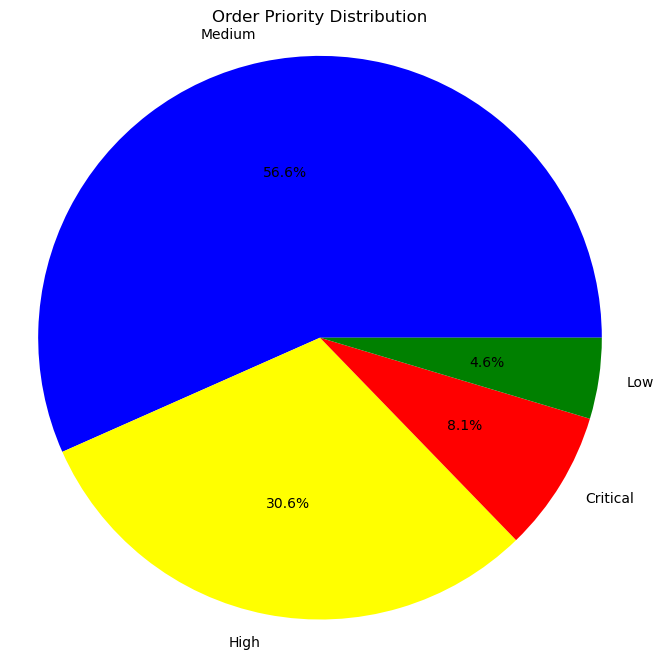

In [9]:
plt.figure(figsize=(8, 8))
plt.pie(order_count, labels=order_count.index,autopct='%1.1f%%', colors=['blue', 'yellow', 'red', 'green'])
plt.title('Order Priority Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot
plt.savefig('Pie chart')

### Group the data by 'Sub-Category' and calculate the sum of 'Profit' for each sub-category

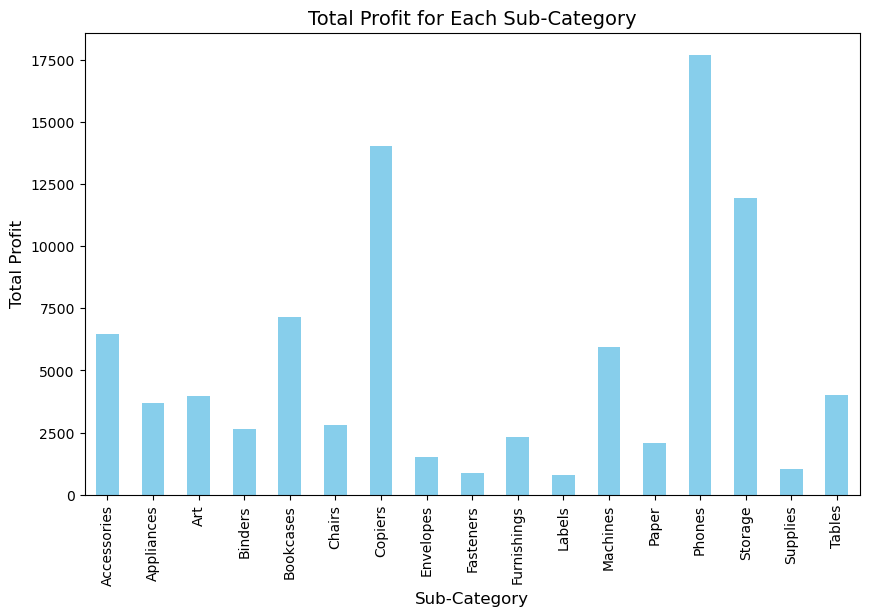

In [10]:
profit = data.groupby('Sub-Category')['Profit'].sum()
# Plot the bar chart
plt.figure(figsize=(10, 6))
profit.plot(kind='bar', color='skyblue')

plt.title('Total Profit for Each Sub-Category', fontsize=14)
plt.xlabel('Sub-Category', fontsize=12)
plt.ylabel('Total Profit', fontsize=12)

plt.savefig('Bar chart')


### Splitting data

In [11]:
# choose dependant vars and undependant var.
X = data.drop(['Shipping Cost'],axis=1)
y = data['Shipping Cost']

# Split data into Train and validation set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


### Define categorical and numerical features

In [12]:
categorical_features = X.select_dtypes(
   include=["object"]
).columns.tolist()

numerical_features = X.select_dtypes(
   include=["float64", "int64"]
).columns.tolist()


### Preprocessing

In [13]:
preprocessor = ColumnTransformer(
   transformers=[
       ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_features),
       ("num", StandardScaler(), numerical_features),
   ]
)

# First Model: `Gradient Boosting Regressor` 

### Pipeline for model

In [14]:
pipeline1 = make_pipeline(preprocessor,
                         GradientBoostingRegressor(random_state=42),
                         verbose=True   
                   )

#### Access  parameters of a GBRegressor by default

In [15]:
classifier_params = pipeline1['gradientboostingregressor'].get_params()
print("\nClassifier parameters:")
for param, value in classifier_params.items():
    print(f"{param}: {value}")



Classifier parameters:
alpha: 0.9
ccp_alpha: 0.0
criterion: friedman_mse
init: None
learning_rate: 0.1
loss: squared_error
max_depth: 3
max_features: None
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_iter_no_change: None
random_state: 42
subsample: 1.0
tol: 0.0001
validation_fraction: 0.1
verbose: 0
warm_start: False


### Training

In [16]:
print('Fit the model')
pipeline1.fit(X_train, y_train)
y_pred = pipeline1.predict(X_test)

# Generate Gradient Boosting Regressor report
MSE = mean_squared_error(y_test, y_pred) # measurement of the typical absolute discrepancies between a dataset's actual values and projected values.
R2 = r2_score(y_test, y_pred) # measures the square root of the average discrepancies between a dataset's actual values and projected values
MAE = mean_absolute_error(y_test, y_pred) # A statistical metric frequently used to assess the goodness of fit of a regression model is the R-squared (R2) score,
RMSE = mean_squared_error(y_test, y_pred)

print("Gradient Boosting Regressor Report:")
print('MAE : ',MAE)
print('MSE : ',MSE)
print('R2 : ',R2)
print('RMSE : ',RMSE)

Fit the model
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.1s
[Pipeline]  (step 2 of 2) Processing gradientboostingregressor, total=   0.7s
Gradient Boosting Regressor Report:
MAE :  6.1010117480600545
MSE :  270.7254938480834
R2 :  0.8654224374701388
RMSE :  270.7254938480834


#### Visualization of the prediction error of a GB model.

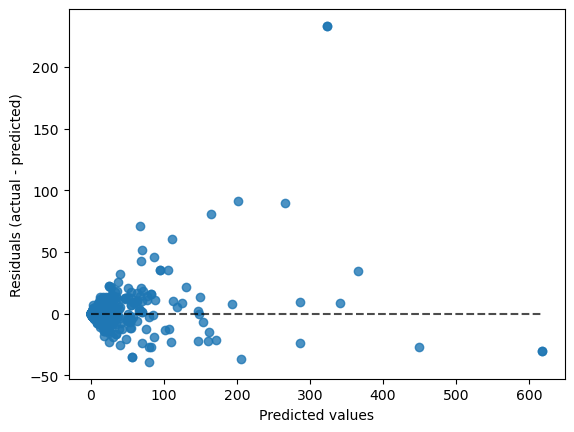

In [17]:
disp = PredictionErrorDisplay.from_estimator(pipeline1, X, y)
plt.show()

# Second Model: Linear Regression Regressor

### Pipeline

In [18]:
pipeline2 = make_pipeline(preprocessor,
                         LinearRegression(),
                         verbose=True   
                   )

### Training

In [19]:
pipeline2.fit(X_train, y_train)
y_pred = pipeline2.predict(X_test)

# Generate Linear Regression report
MSE = mean_squared_error(y_test, y_pred) # measurement of the typical absolute discrepancies between a dataset's actual values and projected values.
R2 = r2_score(y_test, y_pred) # measures the square root of the average discrepancies between a dataset's actual values and projected values
MAE = mean_absolute_error(y_test, y_pred) # A statistical metric frequently used to assess the goodness of fit of a regression model is the R-squared (R2) score,
RMSE = mean_squared_error(y_test, y_pred)

print("Linear Regression Report:")
print('MAE : ',MAE)
print('MSE : ',MSE)
print('R2 : ',R2)
print('RMSE : ',RMSE)

[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.1s
[Pipeline] .. (step 2 of 2) Processing linearregression, total=   0.0s
Linear Regression Report:
MAE :  10.097494665800811
MSE :  392.86189661931985
R2 :  0.8047084679525808
RMSE :  392.86189661931985


#### Visualization of the prediction error of a GB model.

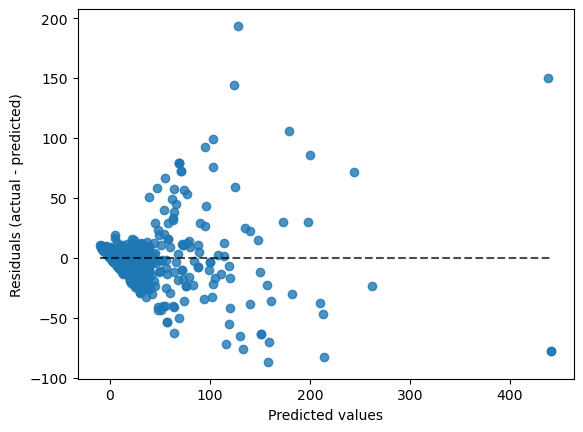

In [20]:
disp = PredictionErrorDisplay.from_estimator(pipeline2, X, y)
plt.show()

### Absence of `hyperparams`:
Linear regressor does not have hyper parameters to modify, for that reason it used only by default params only. 

# Third Model: `KNN regressor`:

### Pipeline for model

In [21]:
pipeline3 = make_pipeline(preprocessor,
                         KNeighborsRegressor(),
                         verbose=True   
                   )

#### Access  parameters of a GBRegressor by default

In [22]:
classifier_params = pipeline3['kneighborsregressor'].get_params()
print("\nClassifier parameters:")
for param, value in classifier_params.items():
    print(f"{param}: {value}")



Classifier parameters:
algorithm: auto
leaf_size: 30
metric: minkowski
metric_params: None
n_jobs: None
n_neighbors: 5
p: 2
weights: uniform


### Training

In [23]:
print('Fit the model')
pipeline3.fit(X_train, y_train)
y_pred = pipeline3.predict(X_test)

# Generate KNN Regression report
MSE = mean_squared_error(y_test, y_pred) # measurement of the typical absolute discrepancies between a dataset's actual values and projected values.
R2 = r2_score(y_test, y_pred) # measures the square root of the average discrepancies between a dataset's actual values and projected values
MAE = mean_absolute_error(y_test, y_pred) # A statistical metric frequently used to assess the goodness of fit of a regression model is the R-squared (R2) score,
RMSE = mean_squared_error(y_test, y_pred)

print("KNNeighbors Regression Report:")
print('MAE : ',MAE)
print('MSE : ',MSE)
print('R2 : ',R2)
print('RMSE : ',RMSE)

Fit the model
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.1s
[Pipeline]  (step 2 of 2) Processing kneighborsregressor, total=   0.0s
KNNeighbors Regression Report:
MAE :  8.444514161220045
MSE :  401.3906589571533
R2 :  0.8004688227292678
RMSE :  401.3906589571533


#### Visualization of the prediction error of a GB model.

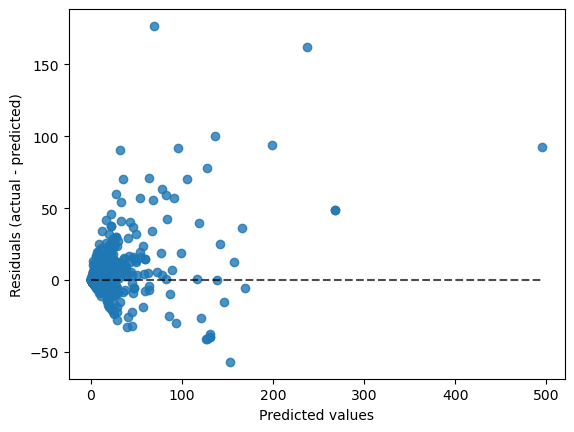

In [24]:
disp = PredictionErrorDisplay.from_estimator(pipeline3, X, y)
plt.show()